In [9]:
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

In [10]:
def step(theta, grad, method, state):
    methods = ('GD','Momentum', 'NAG', 'Adagrad', 'RMSprop', 'Adadelta', 'Adam')
    if method not in methods:
        print "No such method %s" % method
        return theta, state
    
    state = defaultdict(lambda : 0, state)

    if method == "GD":
        eta = state['eta']
        theta_new = theta -  eta * grad(theta)
        state_new = state
        return theta_new, state_new
    
    if method == "Momentum":
        gamma = state['gamma']
        eta = state['eta']
        v = state['v']
        v_new = gamma * v + eta * grad(theta)
        theta_new = theta - v_new
        state['v'] = v_new
        state_new = state
        return theta_new, state_new
    
    if method == "NAG":
        gamma = state['gamma']
        eta = state['eta']
        v = state['v']
        v_new = gamma * v + eta * grad(theta - gamma * v)
        theta_new = theta - v_new
        state['v'] = v_new
        state_new = state
        return theta_new, state_new
    
    if method == "Adagrad":
        G = state['G']
        eps = state['eps']
        eta = state['eta']
        gr = grad(theta)
        if 'G' not in state:
            G = gr**2
        else:
            G += gr**2
        
        theta_new = theta - eta * gr / np.sqrt(G + eps)  
        state['G'] = G
        state_new = state
        return theta_new, state_new
    
    if method == "RMSprop":
        gamma = state['gamma']
        eta = state['eta']
        E = state['E']
        eps = state['eps']
        gr = grad(theta)
        E_new = gamma * E + (1.0 - gamma) * gr ** 2
        theta_new  = theta - eta * gr / np.sqrt(E_new + eps)
        state['E'] = E_new
        state_new = state
        return theta_new, state_new
    
    if method == "Adadelta":
        eps = state['eps']
        gamma = state['gamma']
        Eth = state['Eth']
        Eg = state['Eg']
        dtheta = state['dtheta']
        RMSth = state['RMSth']
        gr = grad(theta)
        Eth_new = gamma * Eth + (1.0 - gamma) * dtheta ** 2
        Eg_new = gamma * Eg + (1.0 - gamma) * gr ** 2
        RMSth_new = np.sqrt(Eth_new + eps)
        RMSg_new = np.sqrt(Eg_new + eps)
        dtheta_new = RMSth / RMSg_new * gr
        theta_new = theta - dtheta_new
        state['Eth'] = Eth_new
        state['Eg'] = Eg_new
        state['RMSth'] =  RMSth_new
        state['dtheta'] = dtheta_new
        state_new = state
        return theta_new, state_new
    
    if method == "Adam":
        eta = state['eta']
        b1 = state['beta1']
        b2 = state['beta2']
        t = state['t'] if state['t'] != 0 else 1
        eps = state['eps']
        gamma = state['gamma']
        m = state['m']
        v = state['v']
        gr = grad(theta)
        m_new = b1 * m + (1.0 - b1) * gr
        v_new = b2 * v + (1.0 - b2) * gr ** 2
        mt = m_new / (1.0 - b1 ** t)
        vt = v_new / (1.0 - b2 ** t)
        theta_new = theta - eta / np.sqrt(vt + eps) * mt
        state['v'] = v_new
        state['m'] = m_new
        state['t'] = t + 1
        state_new = state
        return theta_new, state_new
    

In [45]:
def init_state():
    state = dict()#defaultdict(lambda : 0.0)
    state['eta'] = 0.1
    state['gamma'] = 0.9
    state['eps'] = 1e-8
    state['beta1'] = 0.9
    state['beta2'] = 0.999
    return state

def loss(x):
    return np.sum(x**2)

def dloss(x):
    return (2 * x)

def check_opt(gap = 1000, grad = lambda x : 2 * x, theta = np.array([1.0 , 1.0]), state = init_state(), method = "GD", \
              y_min = np.array([0.0, 0.0]), delta_loss = 0.0000000001, n_epochs = 50000):
    print "Method :", method
    for i in xrange(n_epochs):
        prev_loss = loss(theta)
        theta, state = step(method=method, theta = theta, state = state, grad = dloss)
        curr_loss = loss(theta)
        if np.sum(np.abs(y_min - curr_loss)) < delta_loss:
            print "Theta [%.10f, %.10f]" % (theta[0], theta[1])
            print "Iter %d: f(x)= %0.10f" % (i, loss(theta))
            print "#########################################"
            return i
        if gap != 0:
            if i % 10 == 0 :  print "Iter %d: x=%0.3f f(x)= %0.10f" % (i, theta, loss(theta))
    print "Theta ", theta
    print "Iter %d: f(x)= %0.10f" % (n_epochs, loss(theta))
    print "#########################################"
    return n_epochs

In [12]:
f = (lambda x : x[0]**2 - x[1]**2, \
     lambda x : x[0]**2 + x[1]**2, \
     lambda x : x[0]**2 * np.sin(x[0]) + x[1]**2 * np.sin(x[1]),\
     lambda x : x[0]**2 * np.sin(x[0]**2) + x[1]**2 * np.sin(x[1]**2)
    )
# grad = (lambda x : 2*x[0] - 2*x[1], 
#         lambda x : 2*x[0] + 2*x[1], \
#         lambda x : 2*x[0] * np.sin(x[0]) + x[0]**2 * np.cos(x[0]) + 2*x[1] * np.sin(x[1]) + x[1]**2 * np.cos(x[1]),\
#         lambda x : 2 * (2 * x[0]**2 * np.cos(x[0]**2) + np.sin(x[0]**2)) + 2 * (2 * x[1]**2 * np.cos(x[1]**2) + np.sin(x[1]**2))
#        )
grad = (lambda x : np.array([2*x[0] , -2*x[1]]), 
        lambda x : np.array([2*x[0] , 2*x[1]]),
        lambda x : np.array([2*x[0] * np.sin(x[0]) + x[0]**2 * np.cos(x[0]) , 2*x[1] * np.sin(x[1]) + x[1]**2 * np.cos(x[1])]),
        lambda x : np.array([2 * (2 * x[0]**2 * np.cos(x[0]**2) + np.sin(x[0]**2)) , 2 * (2 * x[1]**2 * np.cos(x[1]**2) + np.sin(x[1]**2))])
       )#change grad[3], error!!!

In [13]:
check_opt(gap = 0, grad = grad[0], state = init_state(), method = 'GD')
check_opt(gap = 0, grad = grad[0], state = init_state(), method = 'Momentum')
check_opt(gap = 0, grad = grad[0], state = init_state(), method = 'NAG')
check_opt(gap = 0, grad = grad[0], state = init_state(), method = 'Adagrad')
check_opt(gap = 0, grad = grad[0], state = init_state(), method = 'RMSprop')
check_opt(gap = 0, grad = grad[0], state = init_state(), method = 'Adadelta')
check_opt(gap = 0, grad = grad[0], state = init_state(), method = 'Adam')

Method : GD
Theta [0.0000049179, 0.0000049179]
Iter 604: f(x)= 0.0000000000
#########################################
Method : Momentum
Theta [0.0000021271, 0.0000021271]
Iter 152: f(x)= 0.0000000000
#########################################
Method : NAG
Theta [0.0000019406, 0.0000019406]
Iter 133: f(x)= 0.0000000000
#########################################
Method : Adagrad
Theta [0.0000049994, 0.0000049994]
Iter 30130: f(x)= 0.0000000000
#########################################
Method : RMSprop
Theta [0.0000031389, 0.0000031389]
Iter 142: f(x)= 0.0000000000
#########################################
Method : Adadelta
Theta [0.0000044005, 0.0000044005]
Iter 1961: f(x)= 0.0000000000
#########################################
Method : Adam
Theta [0.0000049514, 0.0000049514]
Iter 342: f(x)= 0.0000000000
#########################################


342

In [14]:
def get_xyz(xmin, xmax, ymin, ymax, step, f):
    x, y = np.meshgrid(np.arange(xmin, xmax + step, step), np.arange(ymin, ymax + step, step))
    z = f(np.array([x, y]))
    return x, y, z

In [46]:
def get_opt_xyz(grad = lambda x, y : 2*x + 2*y, loss = lambda x, y : x**2 + y**2, n_epochs = 5000,\
                state = init_state(), method = 'GD', theta = np.array([-1.0, -1.0]), gap = 50, bound = 100.0):
    xy = []
    z = []
    for i in xrange(n_epochs):
        if i % gap == 0:
            l = loss(theta)
            if np.abs(l) > bound:
                break
            z.append(loss(theta))
            xy.append(theta)
        theta, state = step(method=method, theta = theta, state = state, grad = grad)
    xy = np.array(xy)
#     print xy
    x = xy[:,0]
    y = xy[:,1]
    return x, y, z

In [8]:
def plot3d(x, y, z, opt_x, opt_y, opt_z, method):
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=0, azim=-30)
    ax.plot_surface(x, y, z, rstride=1, cstride=1, 
                edgecolor='none', alpha=.5, cmap=plt.cm.gray)
#     ax.plot(opt_x, opt_y, opt_z, 'o')
    l = len(opt_z)
    ax.scatter3D(opt_x, opt_y, opt_z, edgecolors='none', s=10.0,c=np.arange(0, l)/float(l),
                cmap = plt.cm.rainbow, alpha=0.5)
    plt.title(method)
    plt.show()

In [52]:
def plot3d_1(x, y, z, opt_x, opt_y, opt_z):
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=50, azim=-120)
    ax.plot_surface(x, y, z, rstride=1, cstride=1, 
                edgecolor='none', alpha=.5, cmap=plt.cm.jet)
#     ax.plot(opt_x, opt_y, opt_z, 'o')
    l = len(opt_z)
    ax.scatter3D(opt_x, opt_y, opt_z, edgecolors='none', s=10.0,c=np.arange(0, l)/float(l),
                cmap = plt.cm.rainbow, alpha=0.5)
    plt.show()

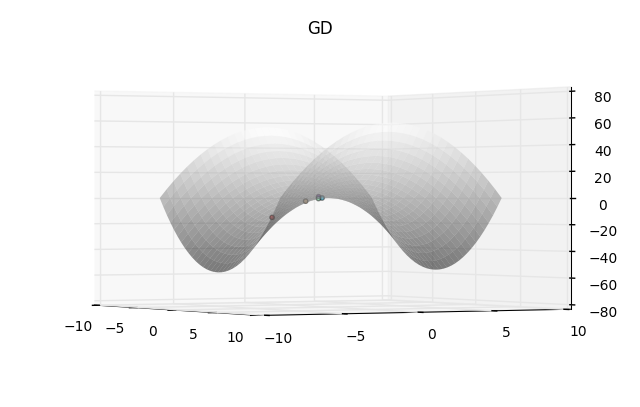

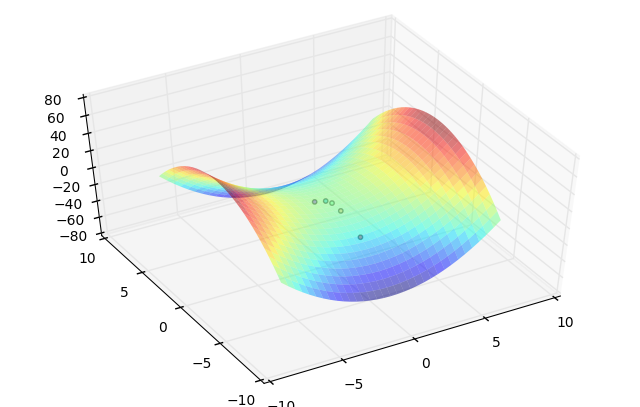

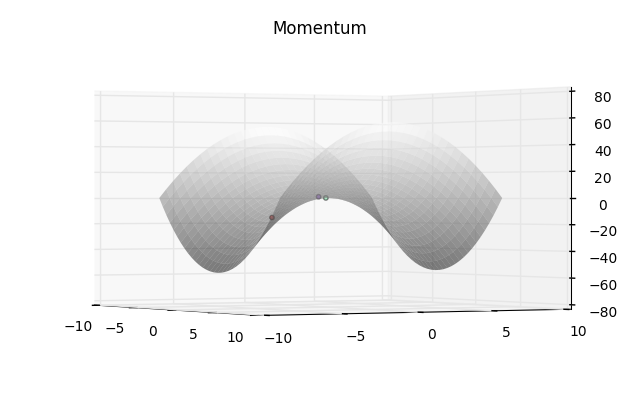

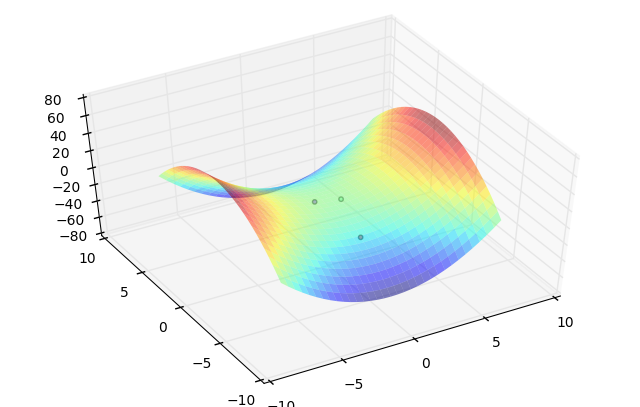

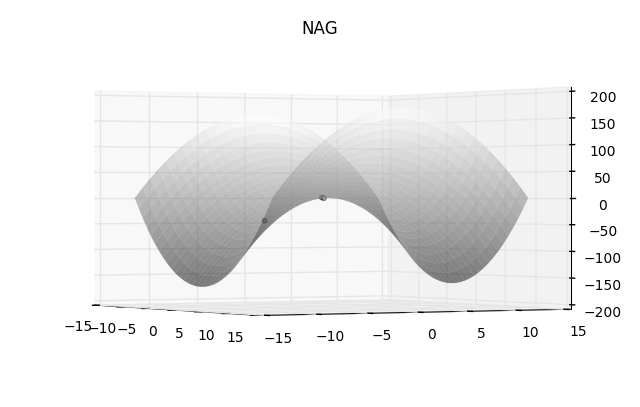

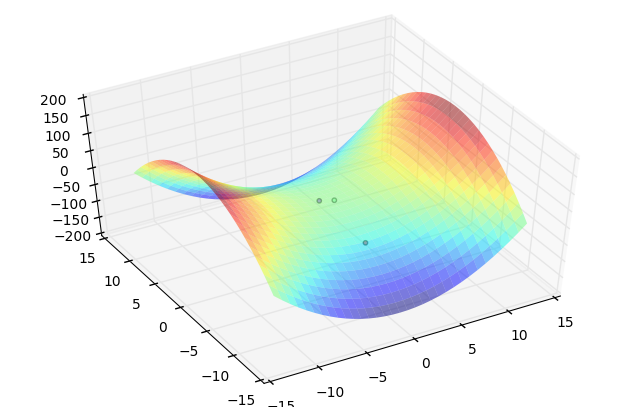

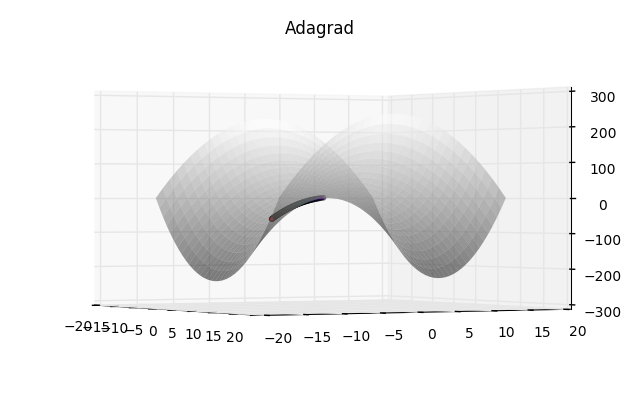

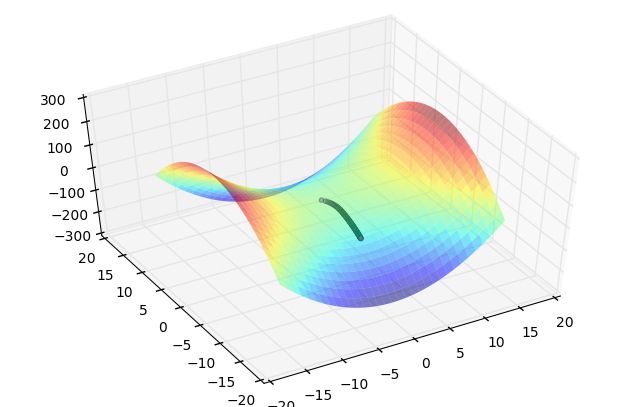

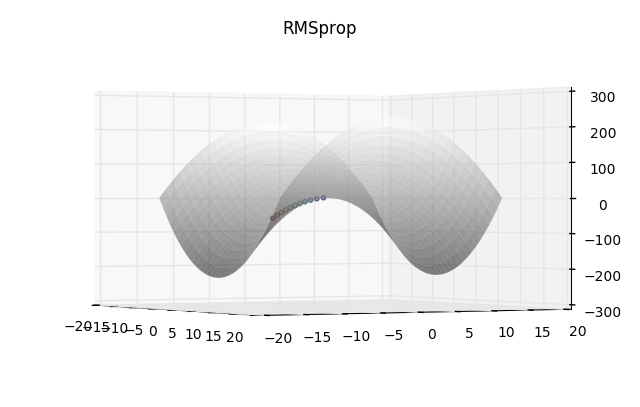

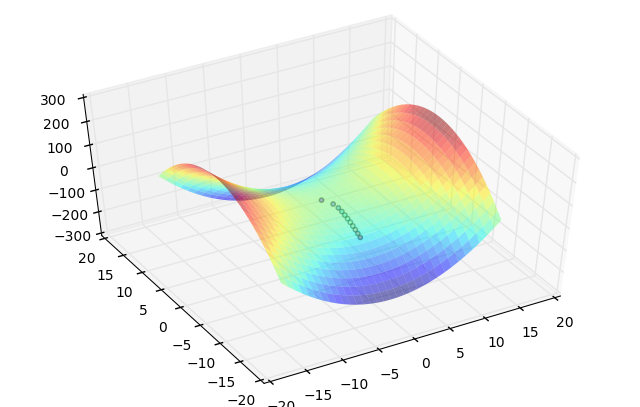

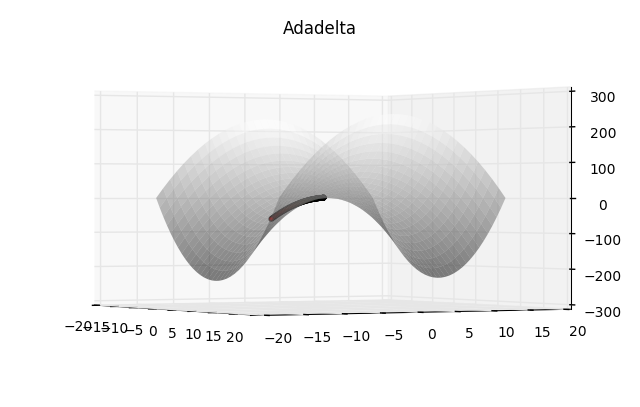

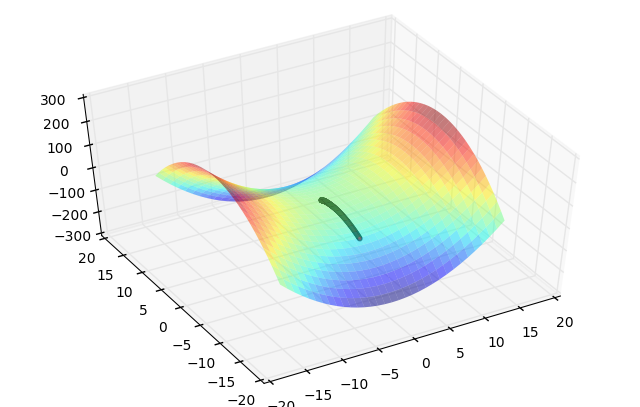

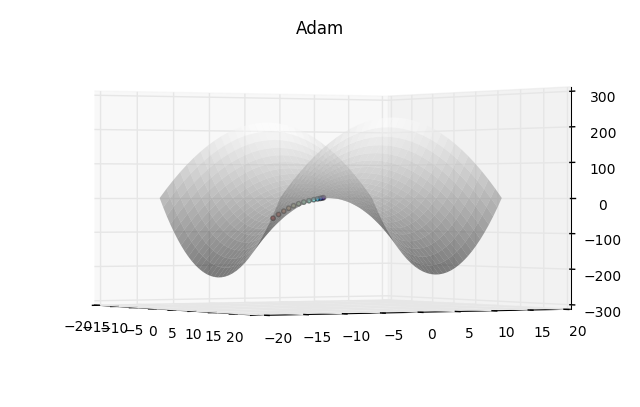

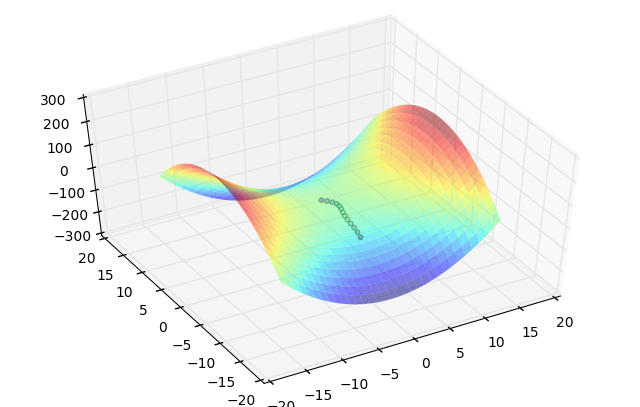

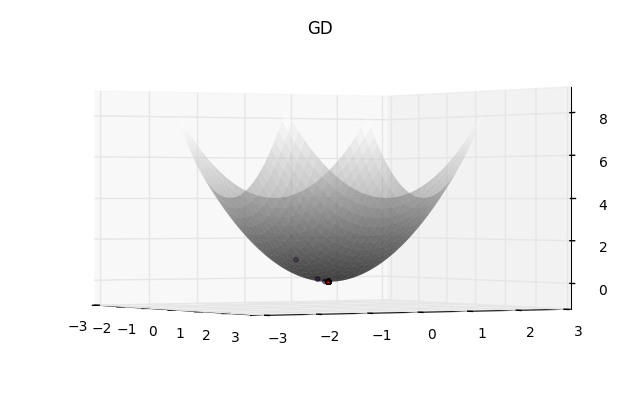

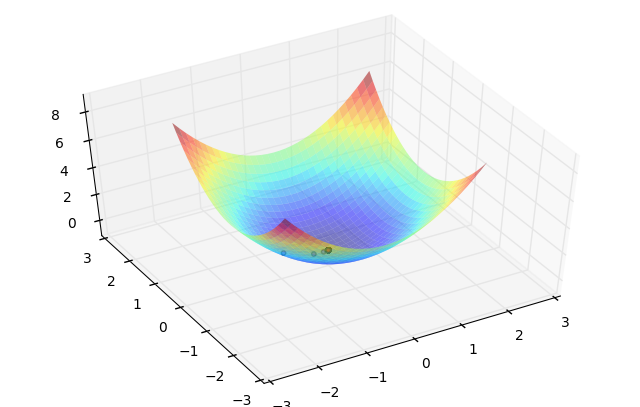

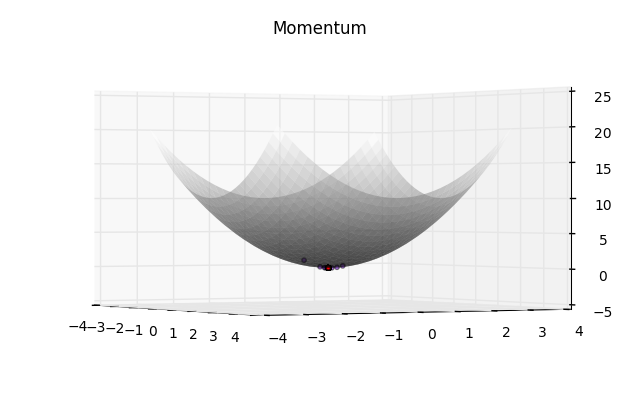

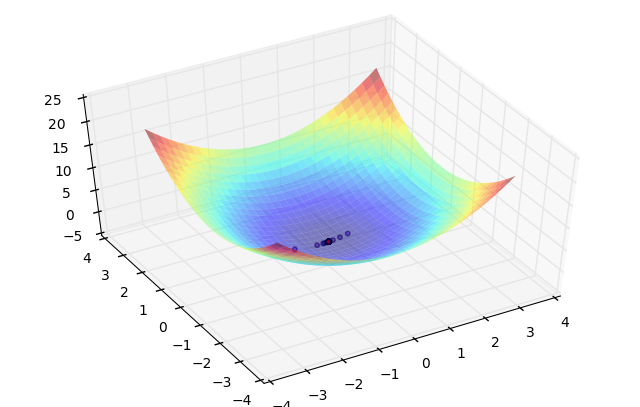

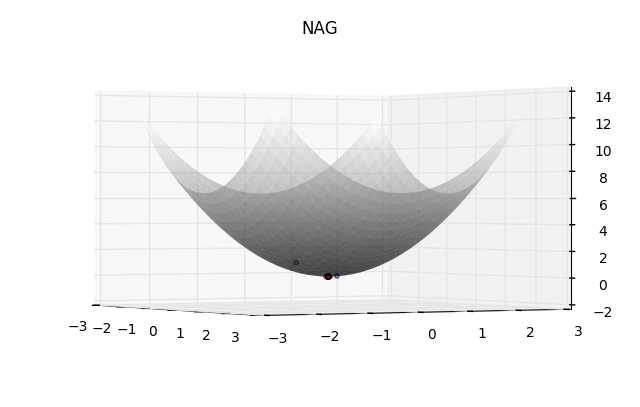

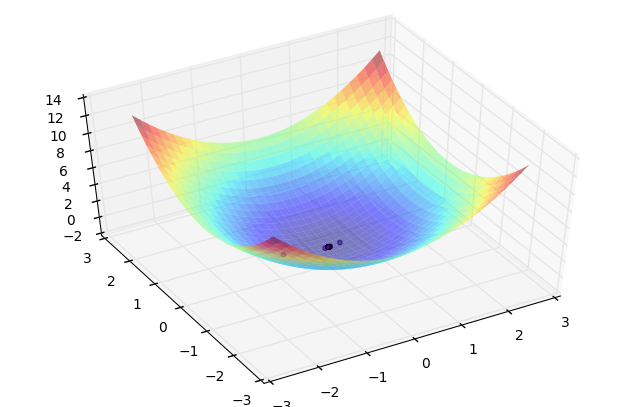

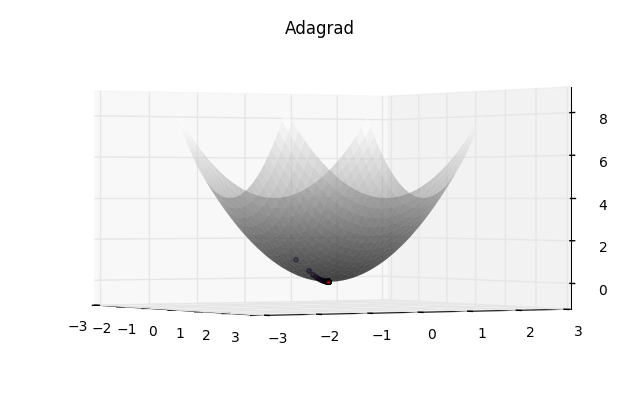

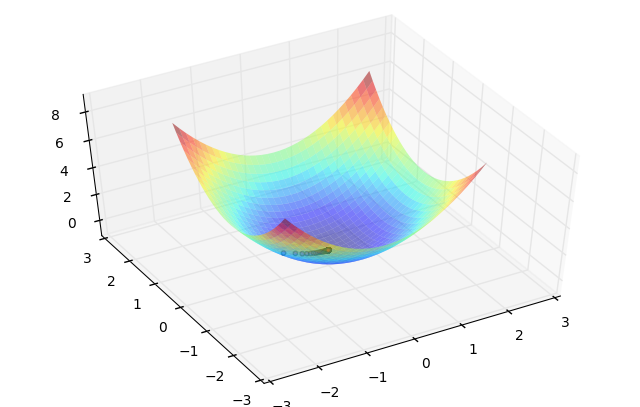

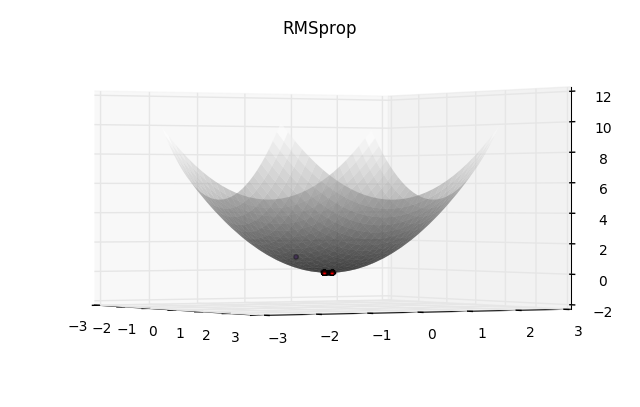

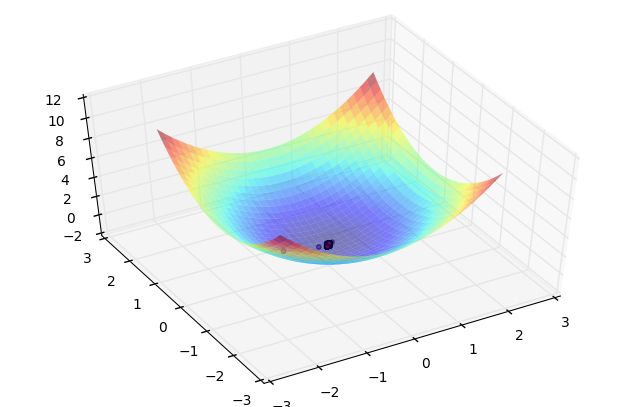

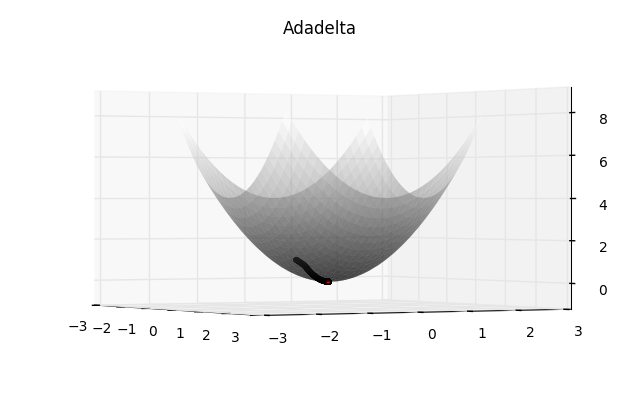

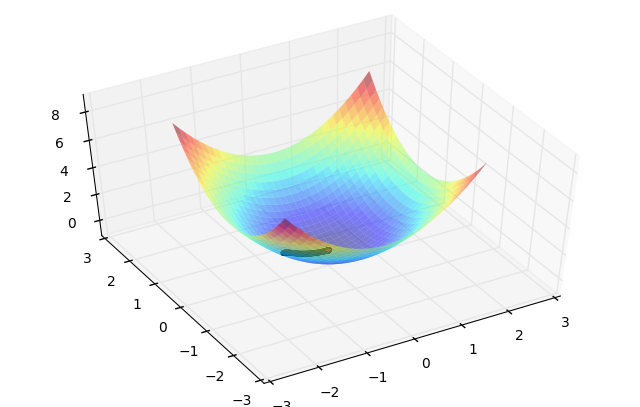

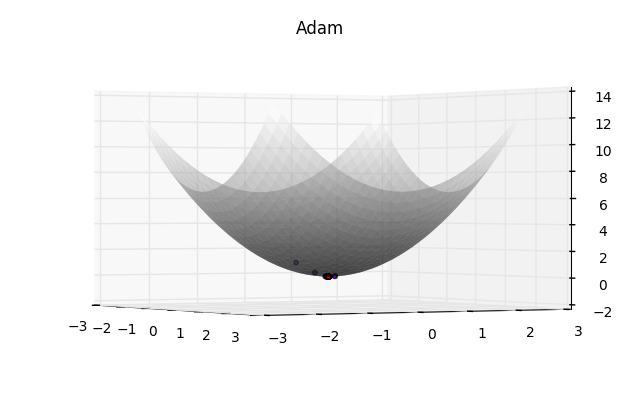

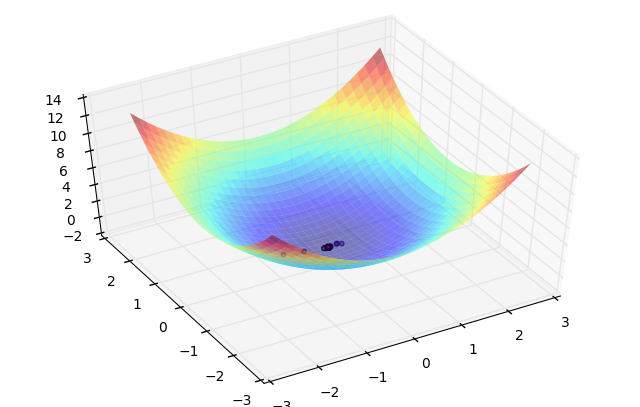

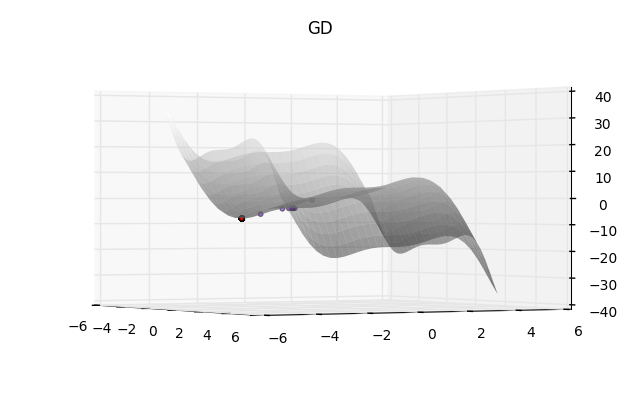

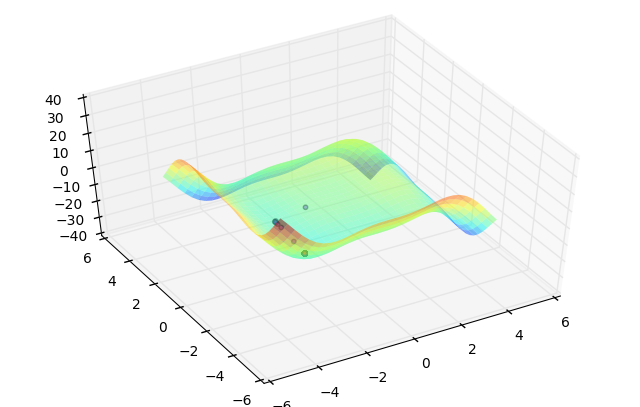

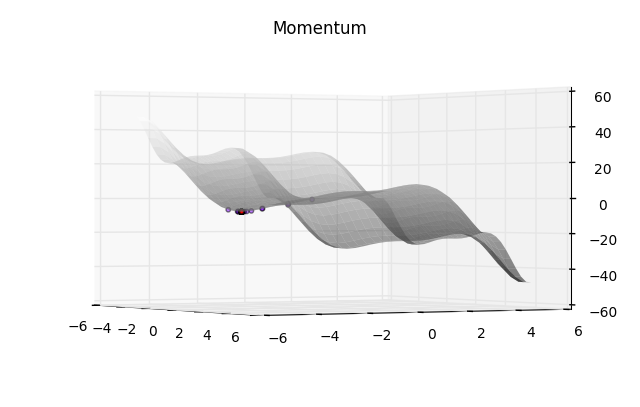

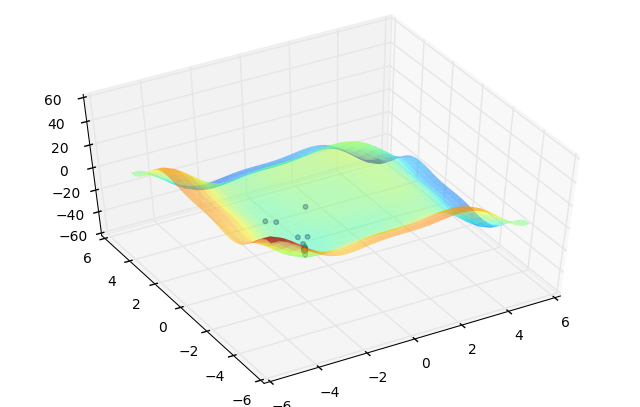

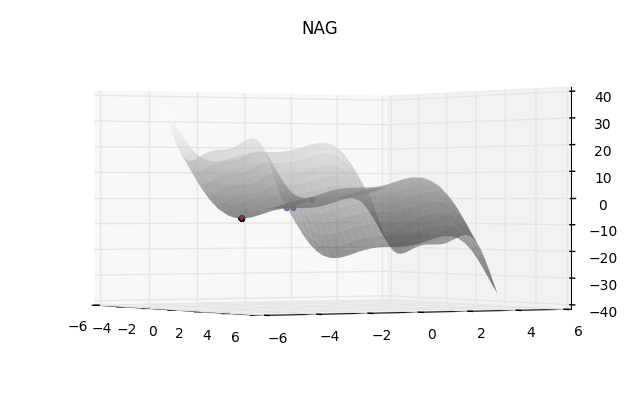

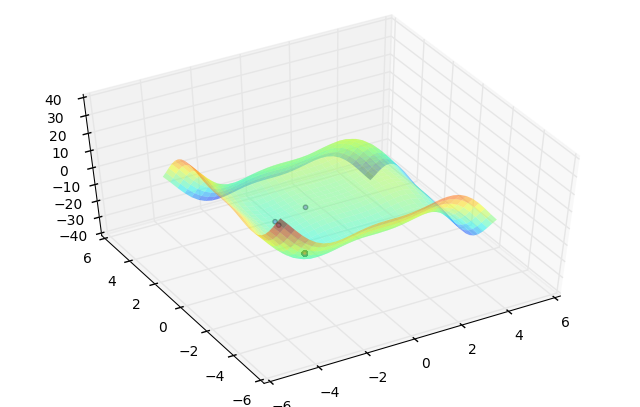

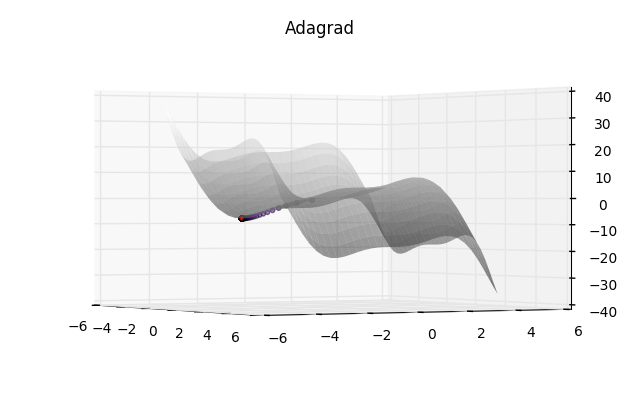

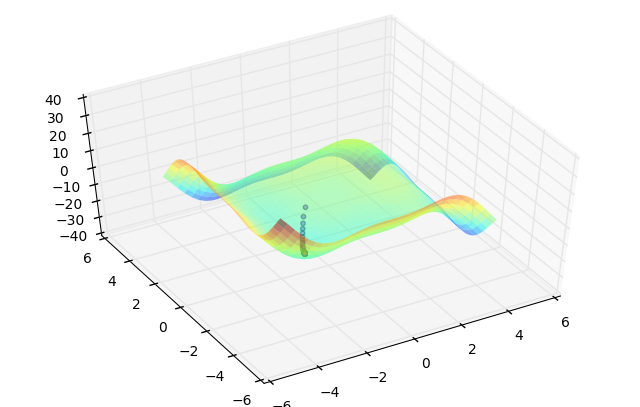

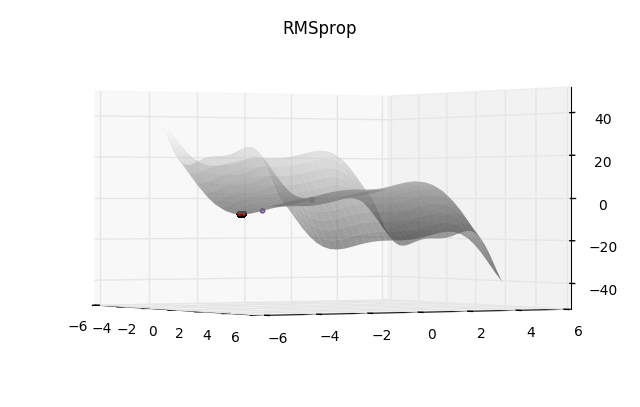

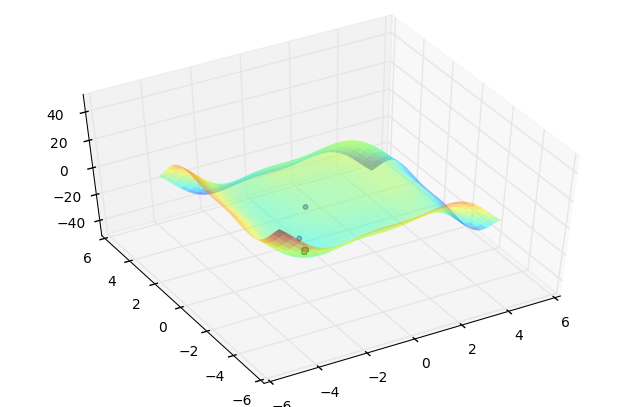

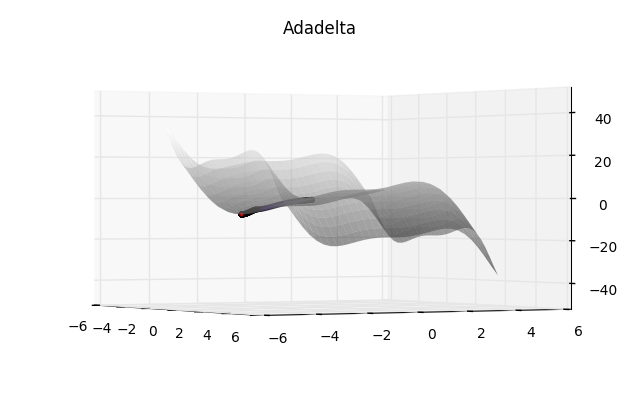

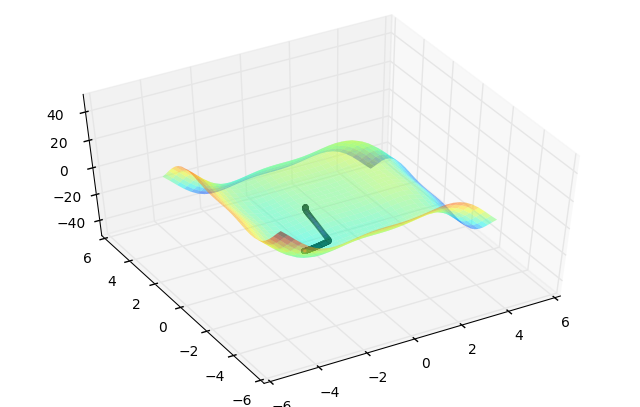

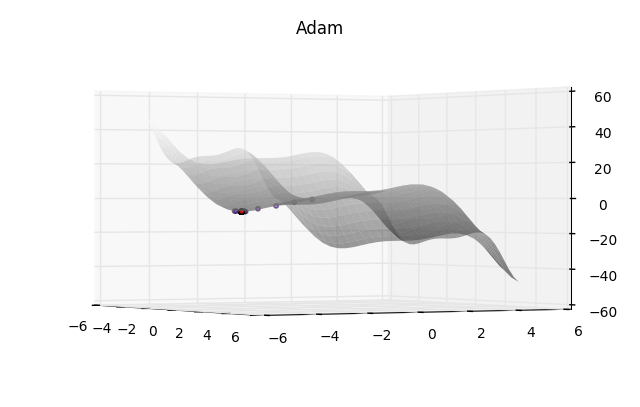

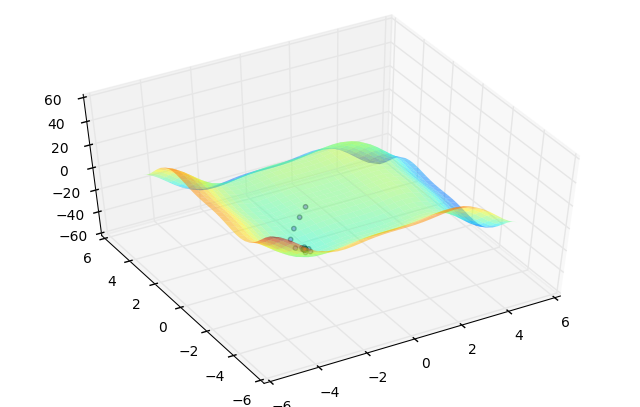

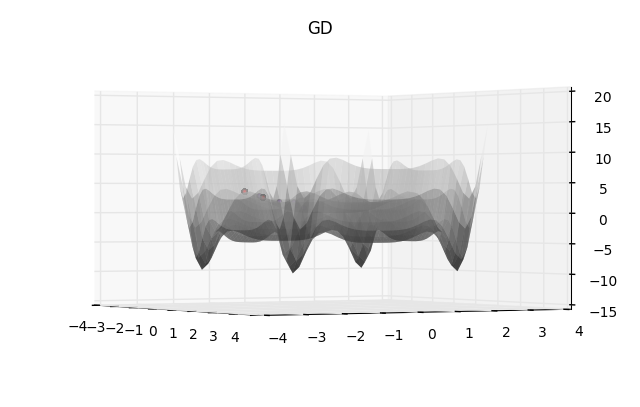

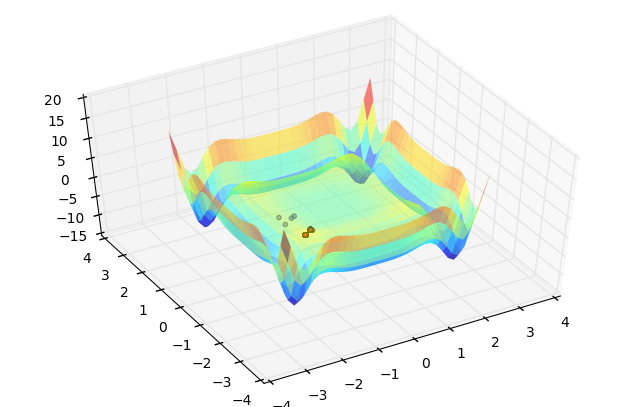

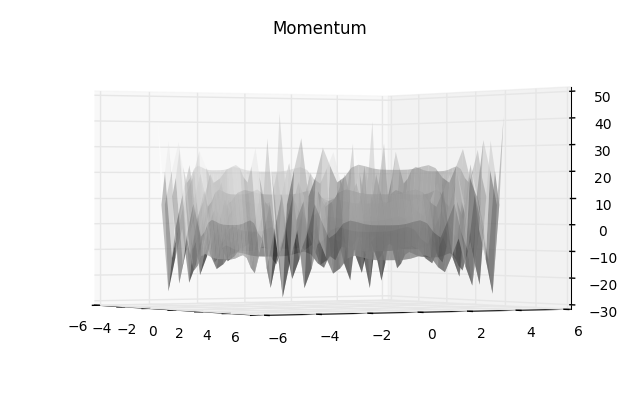

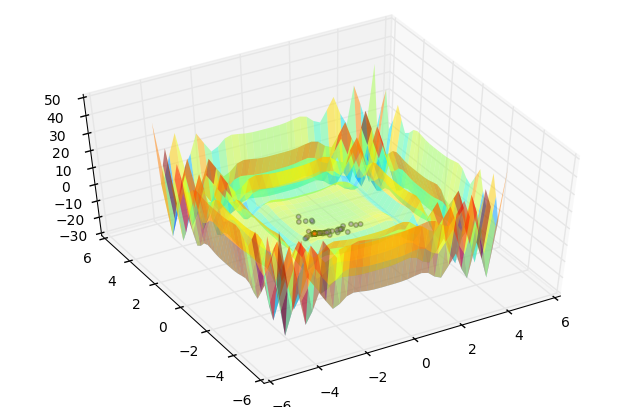

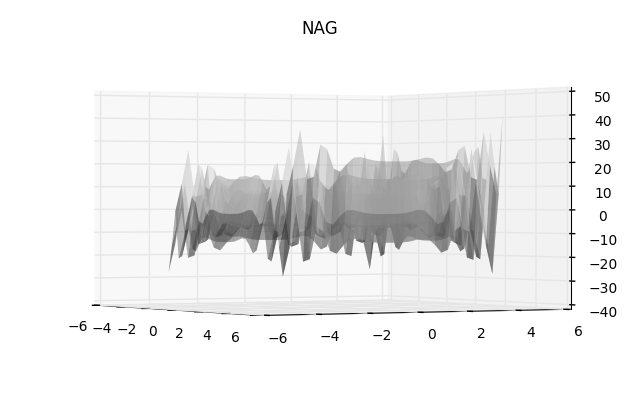

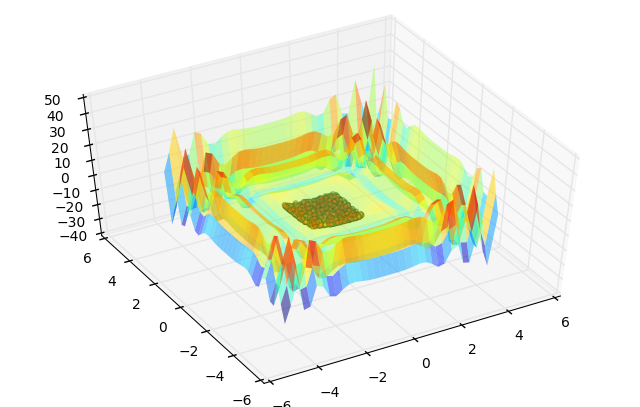

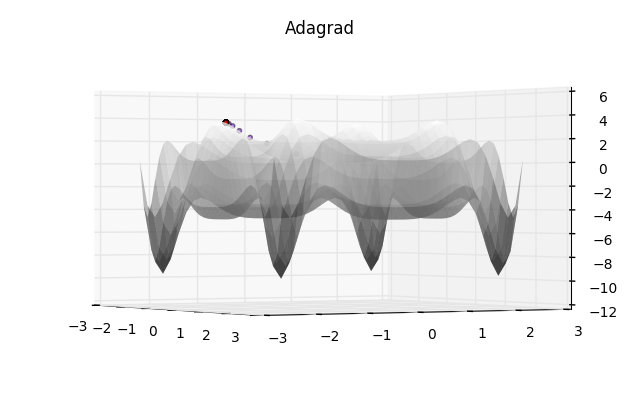

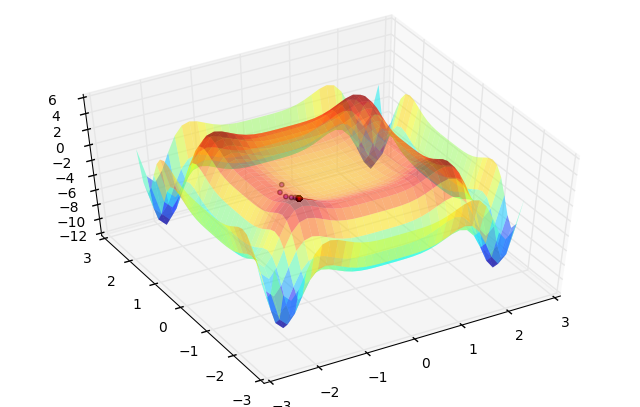

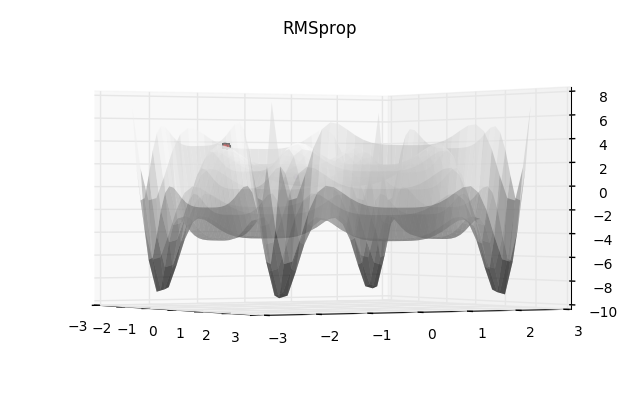

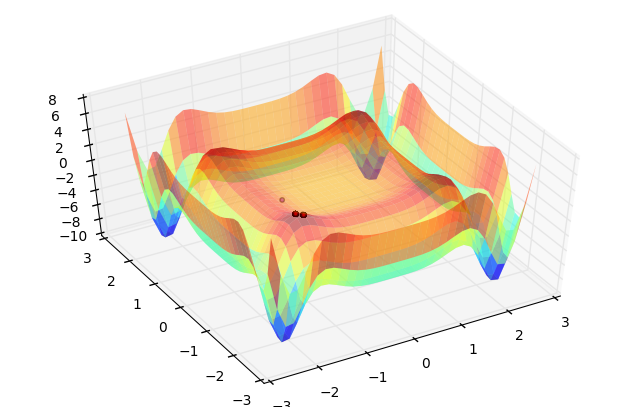

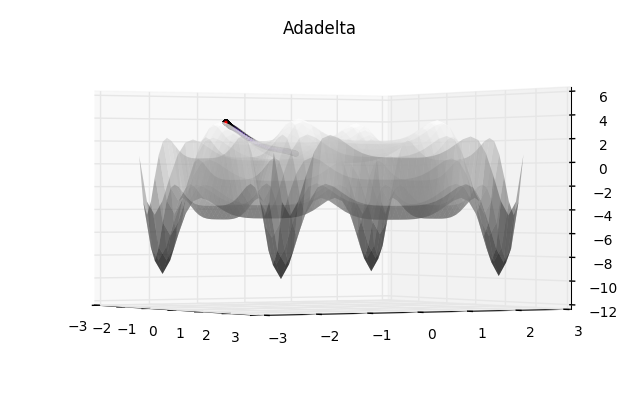

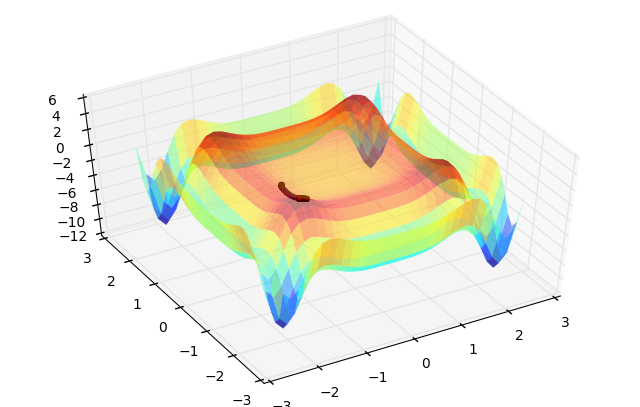

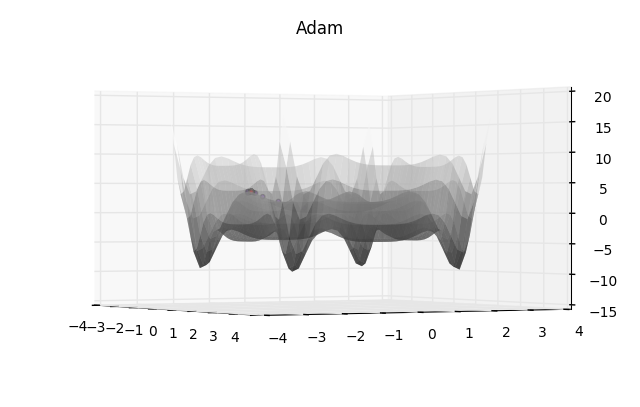

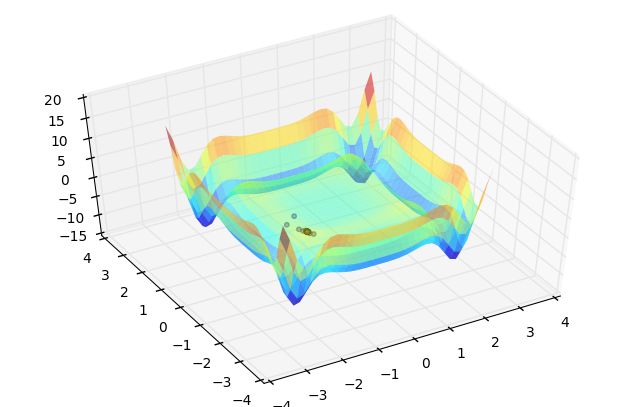

In [55]:
for j in xrange(4):
# j = 3
    for method in ('GD','Momentum', 'NAG', 'Adagrad', 'RMSprop', 'Adadelta', 'Adam'):
        bnd = 60.0
        opt_x, opt_y, opt_z = get_opt_xyz(loss=f[j], grad=grad[j], method=method, n_epochs=10000,\
                                          theta=np.array([-1.0, -0.1]), gap=5, bound = bnd)
        opt_x = np.array(opt_x)
        opt_y = np.array(opt_y)
        opt_z = np.array(opt_z)
        max_bnd = max(opt_x.ptp(), opt_y.ptp()) * 2.0
        x, y, z = get_xyz(-max_bnd, max_bnd, -max_bnd, max_bnd, max_bnd/16.0, f[j])
        plot3d(x, y, z, opt_x, opt_y, opt_z, method)
#         print opt_z
        plot3d_1(x, y, z, opt_x, opt_y, opt_z)

In [ ]:
plt.plot(opt_x, opt_y)